# Treinamento de Modelo
## Descrição

Esse é o primeiro código de treinamento de um modelo. É uma pipeline simples, com o carregamento do dataset, a divisão do conjunto de dados em treino e validação (ainda sem conjunto de testes), o treinamento do modelo e a validação.

## Imports

In [3]:
import os
import sys

import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.utils import shuffle

import mlflow
from mlflow.tracking import MlflowClient


import matplotlib.pyplot as plt
import seaborn as sns

## Extração de Dados

In [4]:
df = pd.read_csv(os.path.abspath("../extracao/data.csv"))

In [5]:
df

,edge_simpl,hue_simpl,average_lum,contrast_ratio,hist_width,blur,score
80184044.jpg,0.988281,17,32.791357,0.033461,0.828125,0.506367,3.911765
3632417985.jpg,0.984701,10,60.394967,0.040131,0.937500,0.509684,4.167411
10344921126.jpg,0.900228,14,82.289109,0.008832,0.820312,0.499054,4.466387
33000255.jpg,0.987467,16,14.709630,0.001770,0.992188,0.490172,4.705508
3091624267.jpg,0.987630,17,20.625202,0.000000,0.800781,0.494483,4.948718
...,...,...,...,...,...,...,...
10264804094.jpg,0.986979,7,70.930692,0.096978,0.921875,0.499980,76.649554
6163705024.jpg,0.983724,17,77.730217,0.089902,0.578125,0.496635,76.649554
7914531096.jpg,0.987630,7,58.468774,0.018675,0.925781,0.502837,76.649554
4824776407.jpg,0.988932,15,66.287623,0.002342,0.882812,0.498488,76.650943


## Formatação dos Dados

Divisão entre os conjuntos de treinamento e de validação. O dataset está ordenado pela qualidade das imagens (alvo da regressão), logo é necessário embaralhar os dados para evitar viés.

Em uma etapa posterior, será utilizada validação cruzada para se ter uma estimativa da precisão das métricas aplicadas.

In [6]:
r_state = 15

X = shuffle(df.iloc[:,:-1], random_state=r_state)

y = shuffle(df.iloc[:,-1], random_state=r_state)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=r_state
)


## Treinamento

Aqui é utilizado um modelo de regressão linear como teste.

In [123]:
model = RandomForestRegressor(max_depth=9,max_features=3,min_samples_split=20,min_samples_leaf=4,n_estimators=100)

In [7]:
model= LinearRegression(fit_intercept=False)

In [8]:
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

## Validação

As métricas utilizadas são a Raíz do Erro Quadrático Médio (rmse), o erro absoluto médio (mae) e coeficiente de determinação (r2), que nos diz o quão bem os dados se encaixam no modelo. 

In [9]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [11]:

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print (f"Desempenho no conjunto de Testes (Validação): {eval_metrics(y_test,y_pred_test)}")
print (f"Desempenho no conjunto de Treino: {eval_metrics(y_train,y_pred_train)}")

Desempenho no conjunto de Testes (Validação): (13.114173821960035, 10.418056211295305, 0.1935475054417264)
Desempenho no conjunto de Treino: (13.56309516576874, 10.743586175895958, 0.18117964236649153)


## Registro dos Resultados

### Inicialização do cliente MLFlow

Tanto esse notebook quanto o MLFlow devem estar rodando em uma mesma máquina hospedeira. É necessário passar o IP da máquina na rede local para realizar a conexão.

In [19]:
def connectMLFlow(MLFlowAddr):
    client = MlflowClient(tracking_uri=MLFlowAddr)
    mlflow.set_tracking_uri(MLFlowAddr)
    return client

In [21]:
client = connectMLFlow("http://172.27.0.1:5000")

In [121]:
experiment_name = "Simple Model"
try:
    experiment_id = client.create_experiment(experiment_name)
except:
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id
    
experiment = mlflow.set_experiment(experiment_name)

In [122]:
run_name = "LinearRegression_default_params"
rmse, mae, r2 = eval_metrics(y_test,y_pred_test)
with mlflow.start_run(run_name=run_name) as run:
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.end_run()

## Análise dos Resultados

Segue uma breve analise do desempenho do modelo e da importância das features.

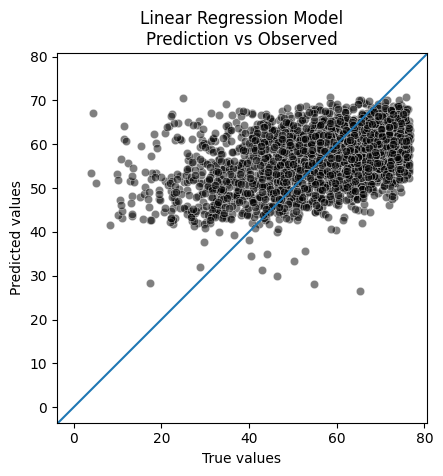

In [12]:
predicted_actual = {
    "True values": y_test, "Predicted values": y_pred_test}
predicted_actual = pd.DataFrame(predicted_actual)

sns.scatterplot(data=predicted_actual,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
plt.axis('square')
_ = plt.title("Linear Regression Model\nPrediction vs Observed")

### Análise da Importância das Features no Modelo

Em um modelo de regressão linear, cada característica está relacionada a um coeficiente, que pode ser interpretado como a taxa de variação da função objetivo em relação a uma mudança na característica correspondente, mantendo as outras constantes.

No gráfico abaixo, podemos ver a magnitude de cada coeficiente.

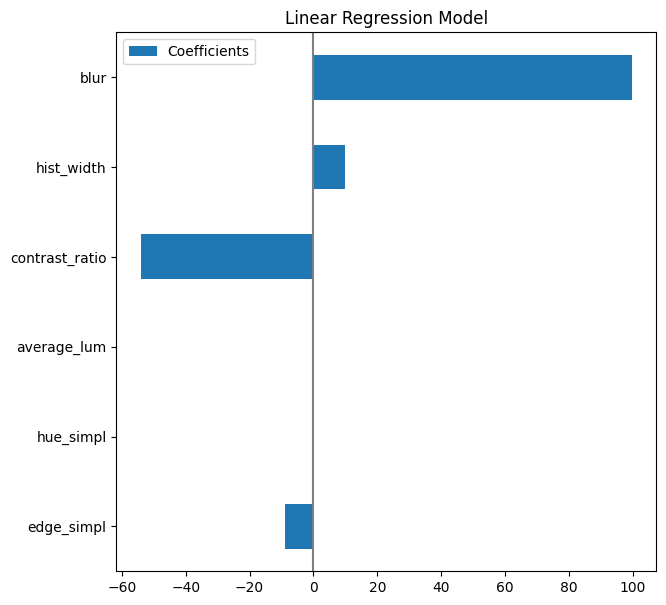

In [13]:
coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear Regression Model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Vemos que uma mudança no desfoque é a que mais impacta o score, mas ainda não podemos concluir que essa é a característica mais importnate. É preciso levar em consideração a escala das variações das características, pois, se houver pouca variação nos dados, mesmo um coeficiente alto pode ter pouco impacto no score predito.

Essa variação pode ser visualizada com o desvio padrão. O framework Pandas oferece medidas de resumo dos dataframes:

In [15]:
X.describe()

,edge_simpl,hue_simpl,average_lum,contrast_ratio,hist_width,blur
count,9349.000000,9349.000000,9349.000000,9349.000000,9349.000000,9349.000000
mean,0.976978,14.157343,44.607939,0.015611,0.827801,0.498695
std,0.040025,4.234862,21.387020,0.049906,0.187379,0.006462
min,0.253092,0.000000,1.882355,0.000000,0.046875,0.458060
25%,0.984212,12.000000,26.865833,0.000000,0.746094,0.496722
50%,0.987630,16.000000,45.737270,0.000000,0.902344,0.498919
75%,0.988607,17.000000,62.044762,0.008225,0.972656,0.500797
max,1.010742,19.000000,89.704538,0.620022,0.992188,0.572941


Vemos que as 4 características com os maiores coeficientes (que são visíveis no gráfico acima) possuem desvio padrão menor que um, sendo que o desfoque (blur) é o menor deles, com 0.006462. Isso pode ser a causa do destaque dessas caracteŕisticas no gráfico acima.

Abaixo, é feita um pipeline com um scaler padrão, que transforma os dados de entrada para que tenham média 0 e desvio padrão igual à 1. Plotando os coeficientes do novo modelo, podemos ver que a luminância média é que tem maior importância, seguida do contraste e largura do histograma. São as três características que fazem o conjunto de simplicidade de luminância.

In [16]:
model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, y_train)


y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print (f"Desempenho no conjunto de Testes (Validação): {eval_metrics(y_test,y_pred_test)}")
print (f"Desempenho no conjunto de Treino: {eval_metrics(y_train,y_pred_train)}")

Desempenho no conjunto de Testes (Validação): (13.112193261970809, 10.41689778819186, 0.19379107502612658)
Desempenho no conjunto de Treino: (13.56070762578125, 10.736523930736844, 0.18146789431106947)


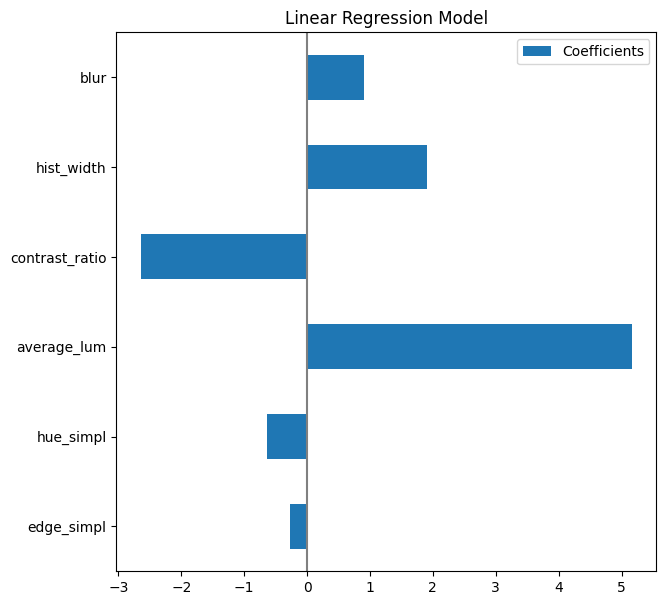

In [147]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear Regression Model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
